# Импорт библиотек

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Загрузка данных

In [1]:
import pandas as pd
df = pd.read_csv('invest_db.csv', sep=';', decimal=',')
df.head()

,id,date,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,forts_flg,margin_status_flg,...,portf_fnd_amt,portf_opt_amt,portf_ore_amt,ccr_balance_amt,cor_balance_amt,lon_balance_amt,posts,comments,reacts,reads
0,1479787897,2024-04-20,33,NaN,UNM,0.0,31272.0,2023-09-13,1,0,...,428.0,0.0,0.0,-11298.0,541.0,0.0,0.0,0.0,0.0,0.0
1,601760063,2024-02-01,29,GRD,UNM,0.0,6284.0,2021-03-29,0,0,...,23.0,0.0,0.0,NaN,8115.0,0.0,0.0,0.0,0.0,0.0
2,61175329,2024-02-10,38,SCH,MAR,0.0,1904.0,2023-12-05,1,0,...,193.0,0.0,0.0,0.0,25.0,NaN,0.0,0.0,0.0,2.0
3,1411700618,2024-03-05,64,NaN,NaN,0.0,NaN,2021-09-16,0,0,...,0.0,0.0,0.0,NaN,65.0,NaN,0.0,0.0,0.0,0.0
4,2096755145,2024-02-10,31,NaN,UNM,0.0,NaN,2022-03-01,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458370 entries, 0 to 458369
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        458370 non-null  int64  
 1   date                      458370 non-null  object 
 2   age                       458370 non-null  int64  
 3   education_level_cd        233460 non-null  object 
 4   marital_status_cd         267030 non-null  object 
 5   children_cnt              410310 non-null  float64
 6   monthly_income_amt        355140 non-null  float64
 7   invest_utilization_dt     458370 non-null  object 
 8   forts_flg                 458370 non-null  int64  
 9   margin_status_flg         458370 non-null  int64  
 10  qualified_investor_flg    458370 non-null  int64  
 11  in_payment_rub_amt        458370 non-null  float64
 12  out_payment_rub_amt       458370 non-null  float64
 13  uncovered_position_amt    458370 non-null  f

# Обработка пропусков

In [60]:
df.isna().mean()[df.isna().mean()>0].sort_values(ascending=False)  # доля пропусков по колонкам


,0
lon_balance_amt,0.676019
education_level_cd,0.490673
marital_status_cd,0.417436
ccr_balance_amt,0.364396
monthly_income_amt,0.225211
children_cnt,0.104850
posts,0.042149
reacts,0.042149
comments,0.042149
reads,0.042149


In [61]:
print("Объем заемных средств равен 0:",sum(df.lon_balance_amt==0))
print("Объем заемных средств больше 0:",sum(df.lon_balance_amt>0))
print("Объем заемных средств не известне:",sum(df.lon_balance_amt.isna()))

Объем заемных средств равен 0: 93471
Объем заемных средств больше 0: 3924
Объем заемных средств не известне: 309867


Признак lon_balance_amt содержит 67% пропусков, а среди оставшихся значений только 3 900 клиентов действительно использовали заемные средства и около 9 000 имеют нулевой остаток. Доля пользователей этого инструмента составляет менее 1%, поэтому анализ по этому признаку нерепрезентативен для построения портрета типичного клиента.
Поэтому столбец был исключён из анализа, чтобы не искажать результаты и не переносить шум в модель.

In [62]:
df = df.drop(columns=['lon_balance_amt'])

Образование и семейное положение достаточно важные данные, поэтому пропуски мы заполним значением "unknown".

In [63]:
cat_cols = ['education_level_cd', 'marital_status_cd']

for col in cat_cols:
    df[col] = df[col].fillna('unknown')

Далее обработать активности: posts, reacts, comments, reads. Если в этих данных нет данных, можно предположить, что активности не было и можно заменить Nan на 0.

In [64]:
activity_cols = ['posts', 'reacts', 'comments', 'reads']

for col in activity_cols:
    df[col] = df[col].fillna(0)

Остальные числовые признаки (children, ccr_balance_amt, cor_balance_amt) можно заменить медианой или модой, если преобладает 0. И добавить столбцы с меткой наличия или отсутствия данных.

In [65]:
# Проверим моду признака количество детей
df.children_cnt.mode()

,children_cnt
0,0.0


In [66]:
df['children_cnt_missing'] = df['children_cnt'].isna().astype(int)
df['children_cnt'] = df['children_cnt'].fillna(df['children_cnt'].mode()[0])

In [67]:
df['monthly_income_missing'] = df['monthly_income_amt'].isna().astype(int)
df['monthly_income_amt'] = df['monthly_income_amt'].fillna(df['monthly_income_amt'].median())

Пропуски в объеме денежных средств на кредитных счетах можно заполнить 0.

In [68]:
df['ccr_balance_has_info'] = (~df['ccr_balance_amt'].isna()).astype(int)
df['ccr_balance_amt'] = df['ccr_balance_amt'].fillna(0)

In [69]:
df['cor_balance_amt'] = df['cor_balance_amt'].fillna(df['cor_balance_amt'].median())

Удалим и преобразуем неинформативные данные

In [70]:
# Преобразуем в datetime
df['date'] = pd.to_datetime(df['date'])
df['invest_utilization_dt'] = pd.to_datetime(df['invest_utilization_dt'])

# Новый признак: сколько дней клиент в сервисе на момент среза
df['invest_days'] = (df['date'] - df['invest_utilization_dt']).dt.days

# На всякий случай: если где-то получилось < 0 (артефакты данных) - обрежем
df['invest_days'] = df['invest_days'].clip(lower=0)

cols_to_drop = [
    'id',
    'date',
    'invest_utilization_dt',
]

df = df.drop(columns=cols_to_drop)


Также некоторые данные можно объединить в группы и сделать единым признаком. Например, группа turnover - объёмы сделок и группа trade_order - количество сделок.

In [71]:
turnover_cols = [col for col in df.columns if col.startswith('turnover_')]
order_cols    = [col for col in df.columns if col.startswith('trade_order_')]

df['turnover_total'] = df[turnover_cols].sum(axis=1)
df['orders_total']   = df[order_cols].sum(axis=1)

df = df.drop(columns=turnover_cols + order_cols)

# Выбор target

In [72]:
df

,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,forts_flg,margin_status_flg,qualified_investor_flg,in_payment_rub_amt,out_payment_rub_amt,...,posts,comments,reacts,reads,children_cnt_missing,monthly_income_missing,ccr_balance_has_info,invest_days,turnover_total,orders_total
0,33,unknown,UNM,0.0,31272.0,1,0,0,9.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,220,0.0,0.0
1,29,GRD,UNM,0.0,6284.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,1039,0.0,0.0
2,38,SCH,MAR,0.0,1904.0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,2.0,0,0,1,67,0.0,0.0
3,64,unknown,unknown,0.0,3143.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,901,54.0,12.0
4,31,unknown,UNM,0.0,3143.0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,1,1,711,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458365,28,unknown,unknown,0.0,3143.0,1,0,0,34.0,0.0,...,0.0,0.0,0.0,21.0,0,1,0,1102,178.0,6.0
458366,46,unknown,unknown,0.0,2524.0,1,0,0,20.0,0.0,...,0.0,0.0,0.0,6.0,0,0,1,1166,38.0,4.0
458367,49,GRD,MAR,0.0,6267.0,1,1,1,0.0,0.0,...,0.0,0.0,0.0,7.0,0,0,1,1106,5933.0,50.0
458368,34,GRD,MAR,1.0,4713.0,1,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,1362,23.0,1.0


Так как для бизнеса один из важнейших признаков это размер портфеля клиента, я сформирую в качестве целевой переменной новый бинарный признак high_value_client. Он показывает, относится ли клиент к верхним 20% по величине портфеля (portf_total_amt). Это отражает ценность клиента для бизнеса, так как клиенты с крупными портфелями генерируют больший потенциальный доход. (Далее я анализировала, чем эти клиенты отличаются по демографии, активности и финансовому поведению от остальных.)

In [73]:
# Посмотрим, какое значение портфеля соответствует верхнему квантилю
q80 = df['portf_total_amt'].quantile(0.8)
print("80-й процентиль портфеля:", q80)

# Создаём таргет, где 1 — наиболее ценные клиенты, 0 — остальные
df['high_value_client'] = (df['portf_total_amt'] >= q80).astype(int)

# Проверим баланс классов
print(df['high_value_client'].value_counts())
print(df['high_value_client'].value_counts(normalize=True))


80-й процентиль портфеля: 51249.20000000001
high_value_client
0    366696
1     91674
Name: count, dtype: int64
high_value_client
0    0.8
1    0.2
Name: proportion, dtype: float64


# Распределение численных признаков

In [76]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

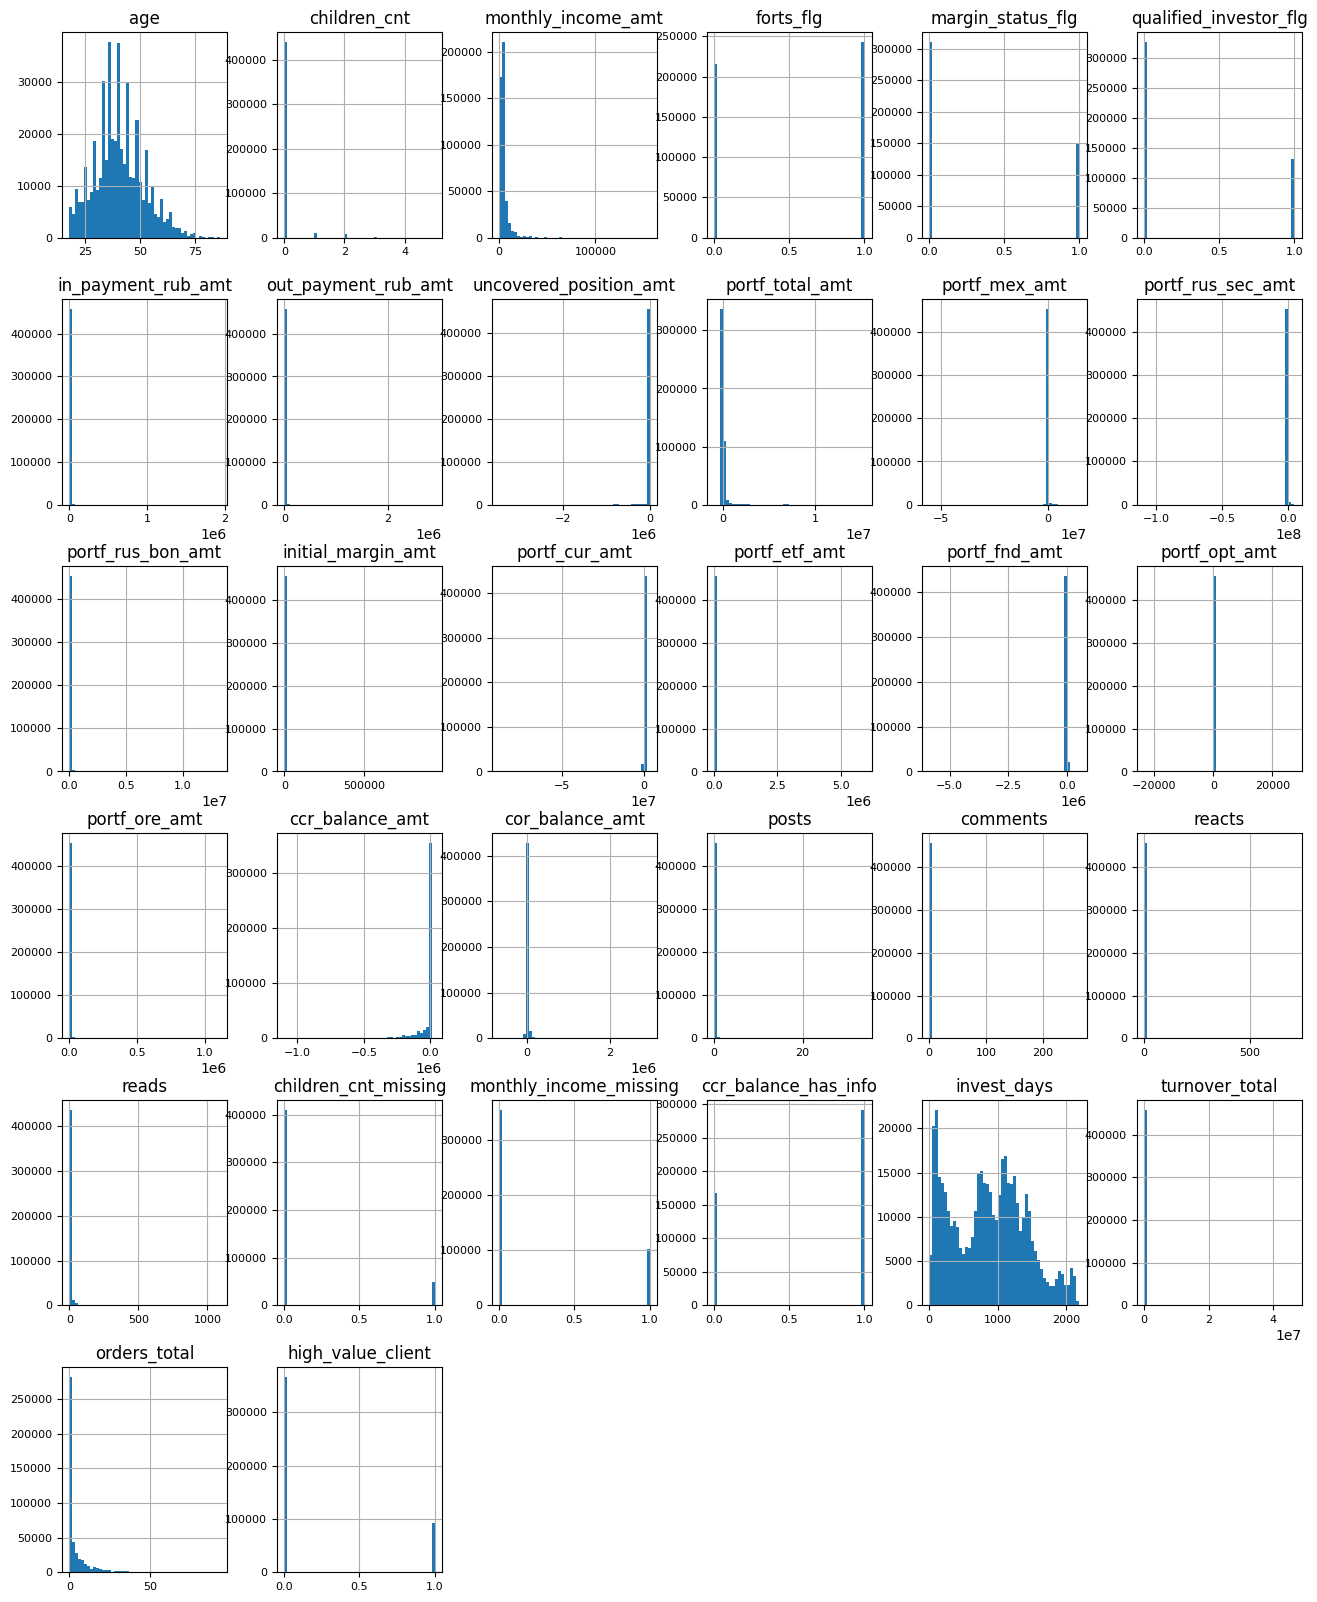

In [79]:
df[num_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

Видим, что многие признаки бинарные.

In [83]:
target = 'high_value_client'

In [84]:
# Бинарные ( 2 уникальных значения)
binary_cols = [
    col for col in num_cols
    if df[col].dropna().nunique() == 2
]

# Убираем таргет из списка бинарных фич
if target in binary_cols:
    binary_cols.remove(target)

# Непрерывные признаки
cont_cols = [
    col for col in num_cols
    if col not in binary_cols and col != target
]


print("Бинарные признаки:", binary_cols)
print("Непрерывные числовые признаки:", cont_cols)

Числовые (все): 32
Бинарные признаки: ['forts_flg', 'margin_status_flg', 'qualified_investor_flg', 'children_cnt_missing', 'monthly_income_missing', 'ccr_balance_has_info']
Непрерывные числовые признаки: ['age', 'children_cnt', 'monthly_income_amt', 'in_payment_rub_amt', 'out_payment_rub_amt', 'uncovered_position_amt', 'portf_total_amt', 'portf_mex_amt', 'portf_rus_sec_amt', 'portf_rus_bon_amt', 'initial_margin_amt', 'portf_cur_amt', 'portf_etf_amt', 'portf_fnd_amt', 'portf_opt_amt', 'portf_ore_amt', 'ccr_balance_amt', 'cor_balance_amt', 'posts', 'comments', 'reacts', 'reads', 'invest_days', 'turnover_total', 'orders_total']


In [86]:
cont_desc = df[cont_cols].describe().T
cont_desc

,count,mean,std,min,25%,50%,75%,max
age,458370.0,40.533674,1.091754e+01,18.0,33.0,40.0,47.0,86.0
children_cnt,458370.0,0.064009,3.354604e-01,0.0,0.0,0.0,0.0,5.0
monthly_income_amt,458370.0,4202.933907,5.450107e+03,0.0,2068.0,3143.0,4403.0,156294.0
in_payment_rub_amt,458370.0,234.774529,5.938802e+03,0.0,0.0,0.0,0.0,1934399.0
out_payment_rub_amt,458370.0,162.432384,6.057344e+03,0.0,0.0,0.0,0.0,2911092.0
uncovered_position_amt,458370.0,-3710.259703,4.719558e+04,-3494045.0,0.0,0.0,0.0,4.0
portf_total_amt,458370.0,60570.106883,3.204279e+05,-942382.0,1812.0,8765.0,36525.0,15318996.0
portf_mex_amt,458370.0,41632.391904,4.027756e+05,-55440642.0,1240.0,6854.0,29473.5,14875172.0
portf_rus_sec_amt,458370.0,14913.592050,5.452302e+05,-108973196.0,487.0,3418.0,14841.0,4828790.0
portf_rus_bon_amt,458370.0,20977.430334,2.057887e+05,0.0,0.0,33.0,4950.0,13275102.0


Сравним средние и медианы между классами нашей целевой переменной.

In [92]:
group_mean = df.groupby(target)[cont_cols].mean().T
group_median = df.groupby(target)[cont_cols].median().T
print("\nСредние значения по классам (0/1):")
display(group_mean)
print("\nМедианы по классам (0/1):")
display(group_median)


Средние значения по классам (0/1):


high_value_client,0,1
age,39.740458,43.706536
children_cnt,0.069453,0.042237
monthly_income_amt,3697.915336,6223.008192
in_payment_rub_amt,80.912903,850.221033
out_payment_rub_amt,68.006730,540.135000
uncovered_position_amt,-1248.848689,-13555.903757
portf_total_amt,10389.357997,261293.102428
portf_mex_amt,5926.939686,184454.200777
portf_rus_sec_amt,3345.846401,61184.574645
portf_rus_bon_amt,2212.977990,96035.239708



Медианы по классам (0/1):


high_value_client,0,1
age,39.0,42.0
children_cnt,0.0,0.0
monthly_income_amt,3143.0,3143.0
in_payment_rub_amt,0.0,0.0
out_payment_rub_amt,0.0,0.0
uncovered_position_amt,0.0,0.0
portf_total_amt,4786.0,118012.5
portf_mex_amt,3797.0,90661.0
portf_rus_sec_amt,2128.0,42129.0
portf_rus_bon_amt,0.0,27923.0


По медиане можно сделать следующие выводы о "ценных" клиентах:


*   Ценные клиенты чуть старше
*   «Идеальные» клиенты дольше пользуются сервисом


*   У «идеальных» клиентов гораздо более крупные портфели по всем направлениям.
*   У них существенно больше облигаций (portf_rus_bon_amt медиана 27k vs 0). Они сильнее представлены и в иностранном направлении (portf_mex_amt), и в российских бумагах, и по кэшу (cor_balance_amt)


Вывод: медиана показывает, что «типичный» клиент мало торгует и мало активен, а отличие идеальных клиентов — в размере и структуре портфеля, возрасте и стаже.





Чтобы поймать различия в активности, нужно смотреть квантили и долю активных, а не только медиану.

In [97]:
quantiles = df.groupby('high_value_client')[[
    'monthly_income_amt', 'children_cnt',
    'turnover_total', 'orders_total',
    'posts', 'comments', 'reacts', 'reads'
]].quantile([0.75, 0.9]).unstack(level=1)
display(quantiles)


monthly_income_amt          children_cnt       \
                                0.75     0.90         0.75 0.90   
high_value_client                                                 
0                             3779.0   6282.0          0.0  0.0   
1                             6291.0  12525.0          0.0  0.0   

                  turnover_total          orders_total       posts       \
                            0.75     0.90         0.75  0.90  0.75 0.90   
high_value_client                                                         
0                         192.00   1837.0          4.0  13.0   0.0  0.0   
1                        1885.75  16367.5          5.0  16.0   0.0  0.0   

                  comments      reacts      reads        
                      0.75 0.90   0.75 0.90  0.75  0.90  
high_value_client                                        
0                      0.0  0.0    0.0  0.0   1.0   8.0  
1                      0.0  0.0    0.0  0.0   3.0  12.0

У топ-клиентов:



*   75/90-й квантиль дохода выше,
*   75/90-й квантиль оборота и числа сделок больше, даже если медиана = 0.


*   И также можно видеть, что они больше читают.



Для признаков, где медиана 0, удобно ввести «есть ли вообще активность».

In [98]:
df['has_turnover'] = (df['turnover_total'] > 0).astype(int)
df['has_orders']   = (df['orders_total'] > 0).astype(int)

for col in ['posts', 'comments', 'reacts', 'reads']:
    df[f'has_{col}'] = (df[col] > 0).astype(int)


In [99]:
flag_cols = ['has_turnover', 'has_orders',
             'has_posts', 'has_comments',
             'has_reacts', 'has_reads']

for col in flag_cols:
    print(f'\n{col}')
    print(df.groupby('high_value_client')[col].mean().round(3))



has_turnover
high_value_client
0    0.453
1    0.492
Name: has_turnover, dtype: float64

has_orders
high_value_client
0    0.453
1    0.492
Name: has_orders, dtype: float64

has_posts
high_value_client
0    0.008
1    0.009
Name: has_posts, dtype: float64

has_comments
high_value_client
0    0.017
1    0.019
Name: has_comments, dtype: float64

has_reacts
high_value_client
0    0.033
1    0.039
Name: has_reacts, dtype: float64

has_reads
high_value_client
0    0.274
1    0.382
Name: has_reads, dtype: float64


Среди клиентов с большими портфелями выше активность.

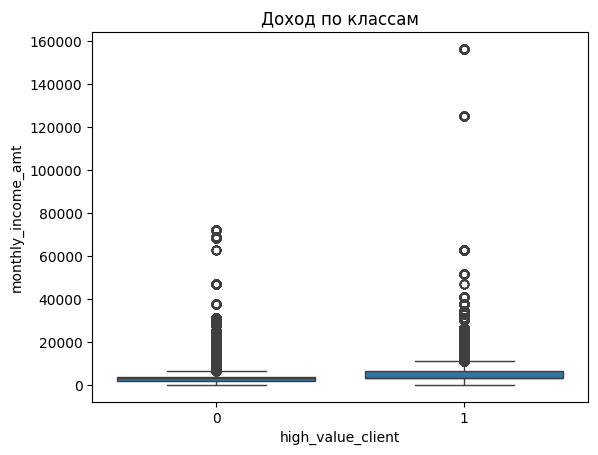

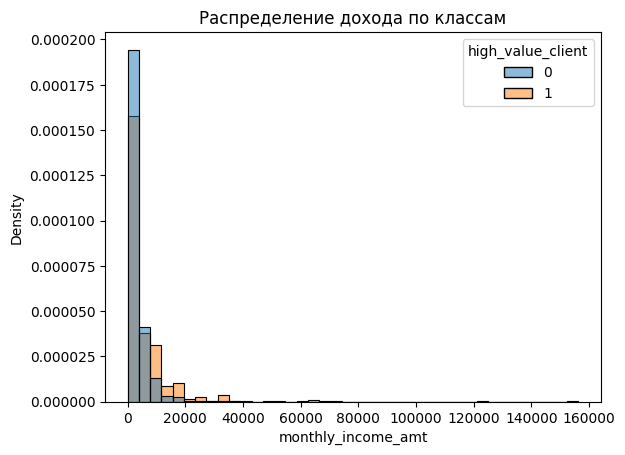

In [100]:
sns.boxplot(data=df, x='high_value_client', y='monthly_income_amt')
plt.title('Доход по классам')
plt.show()

sns.histplot(
    data=df,
    x='monthly_income_amt',
    hue='high_value_client',
    bins=40,
    stat='density',
    common_norm=False
)
plt.title('Распределение дохода по классам')
plt.show()


Доход high_value чаще выше обычных клиентов.

# Категориальные признаки: образование, семейное положение

In [102]:
for col in ['education_level_cd', 'marital_status_cd']:
    print(f'\n=== {col} ===')
    print(
        df.groupby(col)['high_value_client']
          .agg(['mean', 'count'])
          .sort_values('mean', ascending=False)
          .round(3)
    )



=== education_level_cd ===
                     mean   count
education_level_cd               
MGR                 1.000      90
ACD                 0.377    2880
PGR                 0.366    8730
GRD                 0.222  143190
unknown             0.213  224910
UGR                 0.140   31500
SCH                 0.067   47070

=== marital_status_cd ===
                    mean   count
marital_status_cd               
WID                0.238    1890
unknown            0.234  191340
MAR                0.197  129780
UNM                0.160   94770
DIV                0.148   19980
CIV                0.134   20610


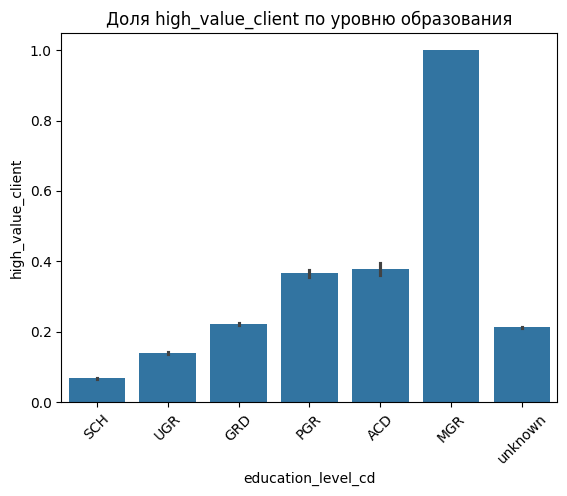

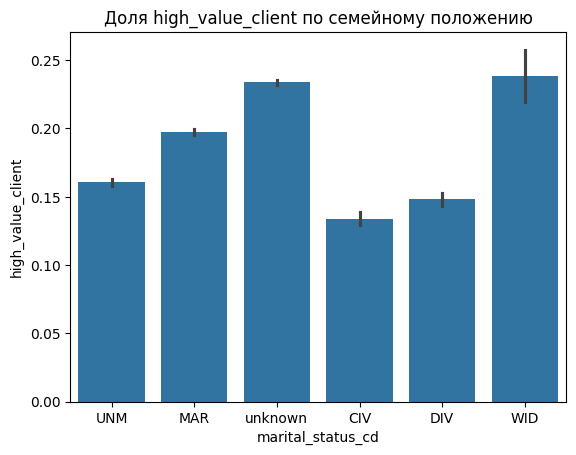

In [104]:
sns.barplot(
    data=df,
    x='education_level_cd',
    y='high_value_client',
    order=['SCH','UGR','GRD','PGR','ACD','MGR','unknown']
)
plt.title('Доля high_value_client по уровню образования')
plt.xticks(rotation=45)
plt.show()

sns.barplot(
    data=df,
    x='marital_status_cd',
    y='high_value_client'
)
plt.title('Доля high_value_client по семейному положению')
plt.show()


Доля “ценных” клиентов заметно возрастает с ростом уровня образования: среди клиентов с базовым образованием (SCH) высокоценными являются ~7%, среди клиентов с высшим - ~22%, а среди клиентов с поствузовским образованием (магистратура/аспирантура/учёная степень) - 36–38%.

По семейному положению эффект слабее, но клиенты, состоящие в браке или овдовевшие, немного чаще попадают в группу high_value (≈20–24%), чем одинокие или разведённые (≈13–16%).

# Корреляционный анализ

/tmp/ipython-input-1765417781.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')


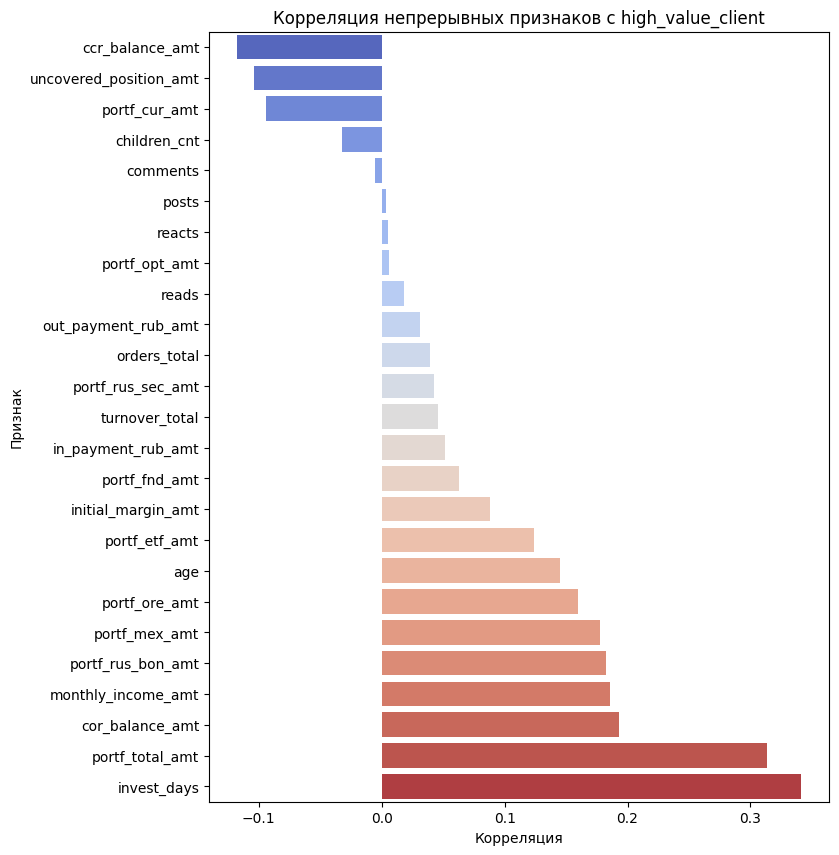

In [125]:
corr_target = (
    df[cont_cols + ['high_value_client']]
    .corr()['high_value_client']
    .drop('high_value_client')
    .sort_values()
)

plt.figure(figsize=(8, 10))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title('Корреляция непрерывных признаков с high_value_client')
plt.xlabel('Корреляция')
plt.ylabel('Признак')
plt.show()


Таким образом, high-value клиент — это человек постарше, с более высоким доходом, давно пользующийся сервисом, с крупным и диверсифицированным портфелем и заметным денежным остатком.

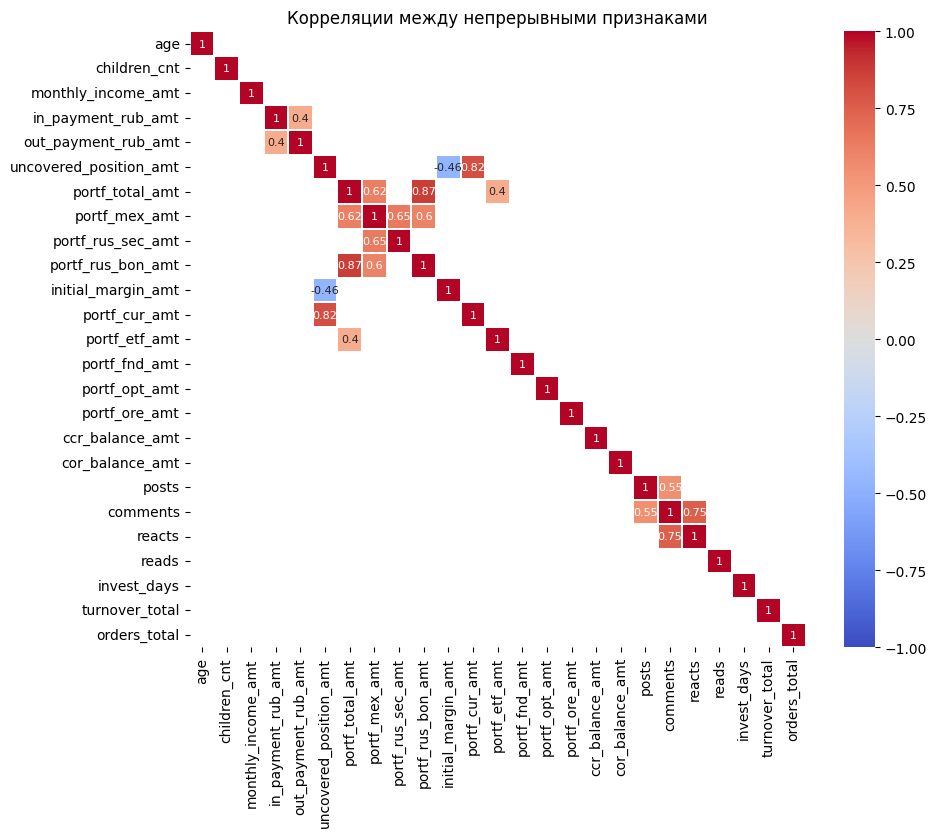

In [123]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[cont_cols].corr(method='pearson')[( df[cont_cols].corr(method='pearson') >= 0.4) | ( df[cont_cols].corr(method='pearson') <= -0.4)],
    cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
    annot=True,
    annot_kws={"size": 8},
    square=True
)
plt.title('Корреляции между непрерывными признаками')
plt.show()


Из данной матрицы корреляции можно понять какие признаки можно будет не использовать в модели, так как они имеют высокую корреляцию между собой (мультиколлинеарность). Соц.активность (posts, reacts, comments, reads) сильно коррелирует внутри себя, то есть их можно объединить в один признак.

In [120]:
corr_bin_with_target = (
    df[binary_cols + [target]]
      .corr()[target]
      .drop(target)
      .sort_values(ascending=False)
)

print("Корреляция бинарных признаков с high_value_client:")
print(corr_bin_with_target)


Корреляция бинарных признаков с high_value_client:
qualified_investor_flg    0.487412
forts_flg                 0.289690
margin_status_flg         0.115567
monthly_income_missing    0.111466
ccr_balance_has_info     -0.085568
children_cnt_missing     -0.105269
Name: high_value_client, dtype: float64


Среди бинарных признаков сильнее всего с high-value статусом коррелируют:

наличие статуса квалифицированного инвестора (qualified_investor_flg, r ≈ 0.49),

использование срочного рынка (forts_flg, r ≈ 0.29),

маржинальный статус (margin_status_flg, r ≈ 0.12).

Это подтверждает, что high-value клиенты более продвинуты: чаще являются квалифицированными инвесторами и используют сложные инструменты (деривативы, маржу).
Все эти фичи можно оставить, они информативны.

In [126]:
for col in binary_cols:
    print(df.groupby(col)[target].mean().round(3))


forts_flg
0    0.077
1    0.309
Name: high_value_client, dtype: float64
margin_status_flg
0    0.168
1    0.267
Name: high_value_client, dtype: float64
qualified_investor_flg
0    0.076
1    0.507
Name: high_value_client, dtype: float64
children_cnt_missing
0    0.214
1    0.077
Name: high_value_client, dtype: float64
monthly_income_missing
0    0.176
1    0.283
Name: high_value_client, dtype: float64
ccr_balance_has_info
0    0.245
1    0.174
Name: high_value_client, dtype: float64


Среди бинарных признаков сильнее всего с high-value статусом связаны признаки продвинутости клиента:

Клиенты с квалифицированным статусом в 6–7 раз чаще попадают в группу high-value (≈51% против 8% для неквалифицированных).

Пользователи срочного рынка (FORTS) в 4 раза чаще оказываются ценными (31% против 8%).

Наличие маржинального статуса также повышает вероятность, но эффект менее выражен (27% против 17%).

# Вывод по EDA

В ходе EDA мы исследовали распределения всех признаков, обработали пропуски, определили target, проанализировали различия между клиентами классов 0 и 1, а также оценили корреляционные связи.
Анализ показал, что high-value клиенты отличаются более высоким стажем инвестирования, крупным и диверсифицированным портфелем, повышенным доходом и использованием продвинутых инструментов (квалифицированный статус, FORTS). Категориальные признаки (образование и семейное положение) демонстрируют слабые, но устойчивые различия, а показатели социальной активности практически не влияют на целевой признак. Полученные результаты позволили выделить информативные признаки и подготовить данные для дальнейшего использования в моделях.